# DVC HOWTO

## Что такое dvc
Data Version Control — это инструмент, который создан для управления версиями моделей и данных в ML-проектах. Он полезен как на этапе экспериментов, так и для развертывания ваших моделей в эксплуатацию.

## Версионирование моделей и данных
Если передать под контроль DVC данные, он начнет отслеживать изменения. Мы можем работать с этими данными точно так же, как с Git: сохранять, отправлять в удалённый репозиторий, получать нужную версию данных, переключаться между версиями. DVC работает поверх Git, частично использует его инфраструктуру и имеет похожий синтаксис.
Преимущества, которые даёт DVC:

* Абстракция кода от данных;
* Хранение данных в любом хранилище;
* Создание пайплайнов по обработке датасетов и их визуализация в консоли;
* Сохранение и отслеживание всех метрик;
* Воспроизведение моделей по созданным пайплайнам

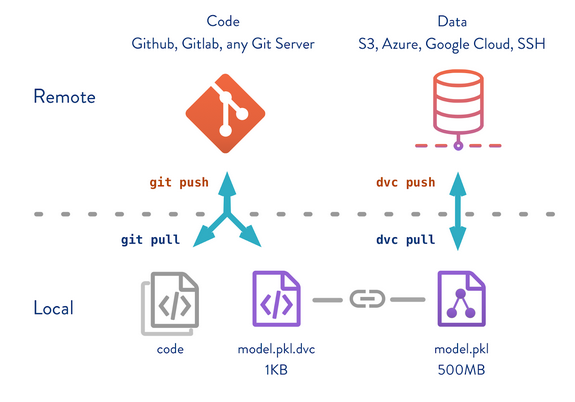


## Почему мы перешли на DVC
* Боль при синхронизации данных между HDFS и машинами с GPU
* Рассинхронизация данных между разработчиками внутри команды
* Необходимость запускать последовательно несколько скриптов для обучения модели

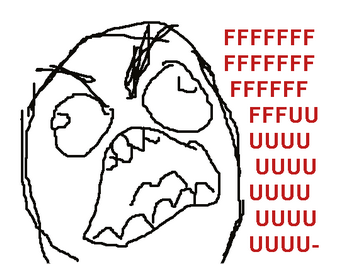

Бонусы
* Теперь мы можем версионировать данные и метрики
* Данные хранятся централизованно в  CEPH
* Если мы сломали расчет фичей, мы можем не пересчитывать их несколько часов, а откатить все за пару минут и получить нужную версию уже рассчитанных фичей.

## DVC DEMO
Создадим небольшой пайплайн из 3 этапов.
На первом мы возьмем датасет, поделим на train и test. На втором обучим модели на train, а на третьем рассчитаем какие-нибудь метрики.

Создадим пустой репозиторий, добавим туда 3 файла и .gitignore

In [1]:
%%bash
rm -rf .dvc .git .gitignore *dvc data/ metrics.txt model.pkl
git init


echo ".ipynb_checkpoints
dvc_demo.ipynb" >> .gitignore

echo "
import pandas as pd
import numpy as np

def get_features(dataset):
    features = dataset.copy()
    # features['sepal_length_to_sepal_width'] = features['sepal_length'] / features['sepal_width']
    # features['petal_length_to_petal_width'] = features['petal_length'] / features['petal_width']
    np.random.seed(42)
    features['is_train'] = np.random.binomial(1, 0.8, size=(len(features),))
    return features
    
if __name__ == '__main__':
    dataset = pd.read_csv('data/iris.csv')
    features = get_features(dataset)
    features.to_csv('data/iris_featurized.csv', index=False)
" > gen_features.py

echo "
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression

def train(dataset):
    model = LogisticRegression(random_state=42)
    X = dataset.drop(columns=['species'])
    y = dataset['species']
    model.fit(X=X, y=y)
    return model

if __name__ == '__main__':
    df = pd.read_csv('data/iris_featurized.csv')
    df = df[df['is_train'] == 1].drop(
        columns=['is_train'])
    model = train(df)
    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)
" > train_model.py

echo "
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score

def test(models, dataset):
    X = dataset.drop(columns=['species'])
    y_true = dataset['species']
    y_pred = model.predict(X=X)
    metrics = accuracy_score(y_true, y_pred)
    return metrics

if __name__ == '__main__':
    df = pd.read_csv('data/iris_featurized.csv')
    df = df[df['is_train'] == 0].drop(
        columns=['is_train'])
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    metrics = test(model, df)
    with open('metrics.txt', 'w') as f:
        f.write(f'Accuracy score: {metrics}\n')
" > eval_model.py

git add gen_features.py train_model.py eval_model.py .gitignore
git status

Инициализирован пустой репозиторий Git в /home/andrei/git/dvc_demo/.git/
На ветке master

Еще нет коммитов

Изменения, которые будут включены в коммит:
  (используйте «git rm --cached <файл>…», чтобы убрать из индекса)
	новый файл:    .gitignore
	новый файл:    eval_model.py
	новый файл:    gen_features.py
	новый файл:    train_model.py



Инициализируем dvc

In [2]:
%%bash
dvc init
echo Git status
git status
git commit -m Init


You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|              https://dvc.org/doc/user-guide/analytics               |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: https://dvc.org/doc
- Get help and share ideas: https://dvc.org/chat
- Star us on GitHub: https://github.com/iterative/dvc
Git status
На ветке master

Еще нет коммитов

Изменения, которые будут включены в коммит:
  (используйте «git rm --cached <файл>…», чтобы убрать из индекса)
	новый файл:    .dvc/.gitignore
	новый файл:    .dvc/config
	новый файл:    .gitignore
	новый файл:    eval_model.py


Скачаем данные. Пусть дальше их отслеживает dvc.
dvc попросит запустить git. Лучше прислушаемся к этому.

In [3]:
%%bash
wget -P data/  https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv
dvc add data/iris.csv
git add data/.gitignore data/iris.csv.dvc


To track the changes with git, run:

	git add data/.gitignore data/iris.csv.dvc


--2020-03-27 17:09:21--  https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv
Распознаётся raw.githubusercontent.com… 151.101.244.133
Подключение к raw.githubusercontent.com|151.101.244.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3716 (3.6K) [text/plain]
Сохранение в: «data/iris.csv»

     0K ...                                                   100% 2.33M=0.002s

2020-03-27 17:09:21 (2.33 MB/s) - «data/iris.csv» сохранён [3716/3716]



In [5]:
!cat data/iris.csv.dvc

md5: 21bad2c7d3a3fac44ebd9620f9d30a73
outs:
- md5: 57fce90c81521889c736445f058c4838
  path: iris.csv
  cache: true
  metric: false
  persist: false


Создадим пайплайны, укажем зависимости. 
С ключом -d указываем зависимости, с ключом -m файлы, в которых метрики, с -o - output пайплайна.
dvc сам добавит нужные файлы в .gitignore и попросит запустить git.

In [6]:
%%bash
# этот пайплайн зависит от data/iris.csv и gen_features.py, а на выходе у него файл data/iris_featurized.csv
dvc run -d data/iris.csv -d gen_features.py -o data/iris_featurized.csv -f gen_features.dvc python gen_features.py
git add data/.gitignore gen_features.dvc

dvc run -d train_model.py -d data/iris_featurized.csv -o model.pkl -f train_model.dvc python train_model.py
git add .gitignore train_model.dvc

dvc run -d eval_model.py -d data/iris_featurized.csv -d model.pkl -m metrics.txt -f eval_model.dvc python eval_model.py
git add .gitignore eval_model.dvc

Running command:
	python gen_features.py

To track the changes with git, run:

	git add gen_features.dvc data/.gitignore
Running command:
	python train_model.py

To track the changes with git, run:

	git add .gitignore train_model.dvc
Running command:
	python eval_model.py

To track the changes with git, run:

	git add .gitignore eval_model.dvc


/home/andrei/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [7]:
!cat gen_features.dvc

md5: be9e646bbe3018d8a467e3bf38c3777d
cmd: python gen_features.py
deps:
- md5: 57fce90c81521889c736445f058c4838
  path: data/iris.csv
- md5: c6155ba1ebef0b98a12fa0e0736d82a6
  path: gen_features.py
outs:
- md5: b444c8005385289881833ffb8130c240
  path: data/iris_featurized.csv
  cache: true
  metric: false
  persist: false


In [8]:
%%bash
# Это для небольшого фокуса
cat eval_model.dvc | egrep metrics.txt -B1

- md5: 3fbacb71e3ebe83e7a4d1aec8b950433
  path: metrics.txt


Можем посмотреть пайплайны

In [9]:
%%bash
dvc pipeline show --ascii eval_model.dvc

                  +-------------------+          
                  | data/iris.csv.dvc |          
                  +-------------------+          
                            *                    
                            *                    
                            *                    
                  +------------------+           
                  | gen_features.dvc |           
                  +------------------+           
                  ***               ****         
               ***                      ***      
             **                            ***   
+-----------------+                           ** 
| train_model.dvc |                        ***   
+-----------------+                     ***      
                  ***               ****         
                     ***         ***             
                        **     **                
                   +----------------+            
                   | eval_model.dvc |            


In [10]:
%%bash
dvc pipeline show --ascii --commands train_model.dvc

                        +------------------------+             
                        | python gen_features.py |             
                        +------------------------+             
                       *****                    ****           
                    ***                             ****       
                 ***                                    ****   
+-----------------------+                                   ***
| python train_model.py |                               ****   
+-----------------------+                           ****       
                       *****                    ****           
                            ***             ****               
                               ***       ***                   
                         +----------------------+              
                         | python eval_model.py |              
                         +----------------------+              

Посмотрим статус пайплайнов

In [11]:
%%bash
dvc status

Data and pipelines are up to date.


Можем посмотреть метрики

In [12]:
%%bash
dvc metrics show

	metrics.txt: Accuracy score: 0.967741935483871


Настало время сделать коммит. У нас первая рабочая версия модели.

In [13]:
%%bash
git commit -m v0

[master fc70d69] v0
 6 files changed, 52 insertions(+)
 create mode 100644 data/.gitignore
 create mode 100644 data/iris.csv.dvc
 create mode 100644 eval_model.dvc
 create mode 100644 gen_features.dvc
 create mode 100644 train_model.dvc


Попробуем перезапустить пайплайн. У нас ничего не поменялось, поэтому dvc ничего не перезапускает

In [14]:
%%bash
dvc repro eval_model.dvc

Data and pipelines are up to date.


Добавим в файл пустую строку. Файл поменяется, а то, что на выходе - нет.
Перезапустим последний пайплайн. dvc увидит, что его зависимости изменились, поэтому надо их выполнить снова.
dvc это заметит, что модель на выходе train_model.dvc не поменялась, и eval_model.dvc повторно запущен не будет.

In [15]:
%%bash
echo >> train_model.py
git add train_model.py
dvc status

train_model.dvc:
	changed deps:
		modified:           train_model.py


In [16]:
%%bash
dvc repro eval_model.dvc
git add train_model.dvc

Running command:
	python train_model.py
Output 'model.pkl' didn't change. Skipping saving.

To track the changes with git, run:

	git add train_model.dvc


/home/andrei/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Теперь внесем более серьезные изменения. Раскомментируем пару строк в gen_features.py.
dvc это видит, видит изменение данных и перезапускает все зависимости.

In [17]:
%%bash
sed -i 's/\#\ //g' gen_features.py
git add gen_features.py
dvc repro eval_model.dvc
git add train_model.dvc gen_features.dvc eval_model.dvc

Running command:
	python gen_features.py
Running command:
	python train_model.py
Running command:
	python eval_model.py

To track the changes with git, run:

	git add train_model.dvc gen_features.dvc eval_model.dvc


/home/andrei/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Посмотрим метрики...

In [18]:
%%bash
dvc metrics show

	metrics.txt: Accuracy score: 1.0


Сделаем коммит

In [19]:
%%bash
git commit -m v1

[master d497115] v1
 5 files changed, 14 insertions(+), 13 deletions(-)


Настало время что-нибудь сломать, иначе зачем нам нужны системы управления версиями?

Удалим фичу petal_length_to_petal_width. Она генерится в восьмой строке.

In [20]:
%%bash
sed -i '8d' gen_features.py
git add gen_features.py

Перезапустим пайплайн, посмотрим метрики.

In [21]:
%%bash
dvc repro eval_model.dvc
git add eval_model.dvc gen_features.dvc train_model.dvc

Running command:
	python gen_features.py
Running command:
	python train_model.py
Running command:
	python eval_model.py

To track the changes with git, run:

	git add gen_features.dvc eval_model.dvc train_model.dvc


/home/andrei/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
%%bash
dvc metrics show

	metrics.txt: Accuracy score: 0.967741935483871


In [23]:
%%bash
git commit -m v2

[master f1c8ab5] v2
 4 files changed, 10 insertions(+), 11 deletions(-)


Метрики ухудшились. Откатим датасет и модель.

Посмотрим на столбцы с данными в файле.

In [24]:
%%bash
head -n1 data/iris_featurized.csv

sepal_length,sepal_width,petal_length,petal_width,species,sepal_length_to_sepal_width,is_train


Откатим последний коммит и возьмем файлы из кэша dvc

In [25]:
%%bash
git reset --hard HEAD~
dvc checkout

HEAD сейчас на d497115 v1


Посмотрим на столбцы с данными в файле. Их стало больше на один.

Желающие могут самостоятельно проверить, что в gen_geatures.py тоже вернулась удаленная строка.

In [26]:
%%bash
head -n1 data/iris_featurized.csv

sepal_length,sepal_width,petal_length,petal_width,species,sepal_length_to_sepal_width,petal_length_to_petal_width,is_train


Пайплайны в актуальном состоянии

In [27]:
%%bash
dvc repro eval_model.dvc

Data and pipelines are up to date.


Просто посмотрим, что мы откатили модель и ее метрики на старом уровне.

In [28]:
%%bash
python eval_model.py
cat metrics.txt

Accuracy score: 1.0


## Что осталось за кадром
Здесь не была рассмотрена возможность хранить файлы в ceph, hdfs или в каком-то другом хранилище. Можно настроить dvc, и по команде dvc pull он будет скачивать кэш из хранилица, а по dvc push он отправит данные в хранилище.
В данном случае все файлы хранятся локально в .dvc/cache. 
Имена файлов соответствуют их контрольным суммам.

In [29]:
%%bash
find .dvc/cache/ -type f

.dvc/cache/5d/5de05235597eea9f5f8f5805707626
.dvc/cache/56/b30e635913d09ff423fb42c77f0d3c
.dvc/cache/3f/bacb71e3ebe83e7a4d1aec8b950433
.dvc/cache/96/5eb800e4e7c8c668fc3da291765d9f
.dvc/cache/b4/44c8005385289881833ffb8130c240
.dvc/cache/68/22876577010aaddb29671bf26adb3a
.dvc/cache/57/fce90c81521889c736445f058c4838
.dvc/cache/32/01a74655551877bdb395414f1022fd
.dvc/cache/58/47593ff1b7c5ef8d3aaee4d13f3823


In [30]:
%%bash
cat eval_model.dvc

md5: 24b7111a13f1f11c75bf257a0d1958ab
cmd: python eval_model.py
deps:
- md5: 6517e44c85ac1ed47c9b686a3b6051ce
  path: eval_model.py
- md5: 5d5de05235597eea9f5f8f5805707626
  path: data/iris_featurized.csv
- md5: 56b30e635913d09ff423fb42c77f0d3c
  path: model.pkl
outs:
- md5: 5847593ff1b7c5ef8d3aaee4d13f3823
  path: metrics.txt
  cache: true
  metric: true
  persist: false


In [31]:
%%bash
echo dvc cache
cat .dvc/cache/58/47593ff1b7c5ef8d3aaee4d13f3823
echo metrics
cat metrics.txt

dvc cache
Accuracy score: 1.0
metrics
Accuracy score: 1.0


In [32]:
%%bash
diff model.pkl .dvc/cache/56/b30e635913d09ff423fb42c77f0d3c
echo $? # файлы совпадают

0


Небольшой фокус. У нас в кэше dvc остался расчет метрики до добавления новых фичей. Раньше я нашел его контрольную сумму и теперь по ней могу найти нужный файл. dvc сделает это автоматически.

In [33]:
!cat .dvc/cache/3f/bacb71e3ebe83e7a4d1aec8b950433

Accuracy score: 0.967741935483871


То есть, версионируя файлы пайплайнов, я версионирую контрольные суммы файлов, отслеживаемых dvc. Заменив при помощи git файл пайплайна, я могу вернуться к старой версии данных, модели и т.п.

git и dvc позволяют мне синхронизировать версии моделей и данных.

## Резюме
* мы узнали, что такое dvc, зачем это нам нужно, и что мы можем потенциально получить
* мы сделали демо с несложным пайплайном, который показывает часть возможностей dvc
* мы увидели как хранятся файлы в кэше dvc

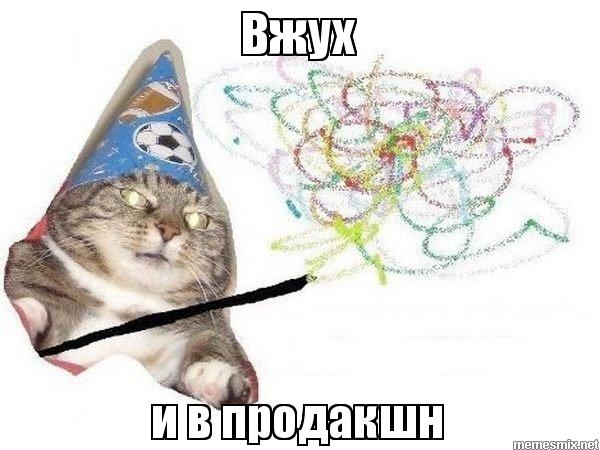

# Спасибо за внимание!